***Rhea Chainani | 22070126086 | AIML B1***

## Installing Dependencies

In [1]:
pip install torch torchvision torchsummary medmnist tensorboard tqdm --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch-fidelity --quiet

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torchmetrics[image] --quiet

Note: you may need to restart the kernel to use updated packages.


## Import Libraries

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
import medmnist
from medmnist import PathMNIST
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import os
from tqdm import tqdm

In [5]:
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance

In [6]:
from torch.cuda.amp import autocast, GradScaler

In [7]:
# Checking if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Load MedMNIST Dataset

The **PathMNIST** dataset is part of the **MedMNIST** collection and is designed for medical image classification tasks. It consists of **pathological tissue images** extracted from **The Cancer Genome Atlas (TCGA)**. The dataset includes **9 classes** of tissues, each representing different pathological conditions. Images are resized to **28×28 pixels** with **RGB channels**, making it suitable for deep learning models like CNNs and GANs. The PathMNIST is widely used for benchmarking medical AI models in **histopathological image analysis**.

In [8]:
# Define dataset transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize images to [-1, 1] for better GAN performance
])

In [9]:
# Load the MedMNIST dataset (PathMNIST for medical images)
root_dir = "/kaggle/working/medmnist_data"
os.makedirs(root_dir, exist_ok=True)

dataset = PathMNIST(root=root_dir, split="train", transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

print("Dataset loaded successfully!")

100%|██████████| 206M/206M [02:34<00:00, 1.33MB/s] 


Dataset loaded successfully!


## Define Generator & Discriminator

In [10]:
class Generator(nn.Module):
    """
    Generator Network for GANs.
    Generates synthetic images from random noise (latent vector).
    """
    def __init__(self, latent_dim=100, img_shape=(3, 28, 28)):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, int(np.prod(img_shape))),  # Output flattened image
            nn.Tanh()  # Normalize output to [-1, 1]
        )

    def forward(self, z):
        """
        Forward pass: Generates an image from latent vector z.
        """
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)  # Reshape to image format
        return img

In [11]:
class Discriminator(nn.Module):
    """
    Discriminator Network for GANs.
    Determines whether an image is real or fake.
    """
    def __init__(self, img_shape=(3, 28, 28)):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            #nn.Linear(3 * 28 * 28, 512), 
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)  # Output single score (real or fake)
        )

    def forward(self, img):
        """
        Forward pass: Classifies an image as real or fake.
        """
        img_flat = img.view(img.size(0), -1)  # Flatten image
        return self.model(img_flat)

In [12]:
def save_generated_images(generator, epoch, latent_dim=100, num_images=16, gan_type="WGAN", base_folder="generated_images"):
    folder = os.path.join(base_folder, gan_type)  # Separate folders per GAN type
    os.makedirs(folder, exist_ok=True)  

    z = torch.randn(num_images, latent_dim).to(device)
    with torch.no_grad():
        fake_imgs = generator(z)

    image_path = f"{folder}/epoch_{epoch}.png"
    vutils.save_image(fake_imgs, image_path, normalize=True)
    
    print(f"Saved: {image_path}")

In [13]:
def evaluate_performance(generator, inception, fid, latent_dim, num_images=100):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim).to(next(generator.parameters()).device)
        fake_imgs = generator(z)
        
    fake_imgs = (fake_imgs + 1) * 127.5  # Convert from [-1,1] to [0,255]
    fake_imgs = fake_imgs.clamp(0, 255).to(torch.uint8)  # Ensure values are within 0-255 and convert to uint8
    
    inception.update(fake_imgs)
    fid.update(fake_imgs, real=False)
    generator.train()

## Define Training Functions

### LS-GAN Training

LSGAN replaces the binary cross-entropy loss used in standard GANs with a **least squares loss function** to stabilize training. By minimizing the **mean squared error** between real and fake labels, LSGAN reduces mode collapse and produces smoother gradients, leading to more realistic image generation.
But it is still susceptible to mode collapse and vanishing gradients.

In [14]:
def train_ls_gan(generator, discriminator, dataloader, epochs=50, latent_dim=100):
    """
    Trains a Least Squares GAN (LS-GAN).
    """
    writer = SummaryWriter(log_dir="./logs/LSGAN")
    criterion = nn.MSELoss()  # Least Squares loss
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

    inception = InceptionScore().to(device)
    fid = FrechetInceptionDistance().to(device)

    for epoch in range(epochs):
        fid.reset()
        
        for i, (imgs, _) in enumerate(dataloader):
            imgs = imgs.to(device)
            
            # Train Discriminator
            optimizer_D.zero_grad()
            z = torch.randn(imgs.size(0), latent_dim).to(device)
            fake_imgs = generator(z).detach()
            
            real_preds = discriminator(imgs)
            fake_preds = discriminator(fake_imgs)

            real_loss = criterion(real_preds, torch.ones_like(real_preds))
            fake_loss = criterion(fake_preds, torch.zeros_like(fake_preds))
            
            d_loss = 0.5 * (real_loss + fake_loss)
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            z = torch.randn(imgs.size(0), latent_dim).to(device)
            gen_imgs = generator(z)
            
            g_loss = criterion(discriminator(gen_imgs), torch.ones_like(discriminator(gen_imgs)))
            g_loss.backward()
            optimizer_G.step()

        if epoch % 5 == 0:
            save_generated_images(generator, epoch, latent_dim, gan_type="LSGAN")

        # Update FID with real & fake images
        fid.update((imgs * 255).to(torch.uint8), real=True)
        fid.update((fake_imgs * 255).to(torch.uint8), real=False)
        
        evaluate_performance(generator, inception, fid, latent_dim)
        
        inception_score = inception.compute()[0].item()
        fid_score = fid.compute().item() if fid.real_features_num_samples > 1 and fid.fake_features_num_samples > 1 else float("inf")
        
        writer.add_scalar("D Loss", d_loss.item(), epoch)
        writer.add_scalar("G Loss", g_loss.item(), epoch)
        writer.add_scalar("Inception Score", inception_score, epoch)
        writer.add_scalar("FID Score", fid_score, epoch)
        
        print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f} | FID: {fid_score:.3f}")

### WGAN Training

WGAN improves training stability by using the **Wasserstein distance (Earth Mover’s distance)** instead of the Jensen-Shannon divergence. It replaces the discriminator with a **critic**, which does not classify but rather **scores** real and fake samples. **Weight clipping** is applied to enforce the Lipschitz constraint. But one of its disadvantages is that weight clipping can limit learning capacity.



In [15]:
def train_wgan(generator, discriminator, dataloader, epochs=50, latent_dim=100, c=0.01):
    """
    Trains a Wasserstein GAN (WGAN) with weight clipping.
    """
    writer = SummaryWriter(log_dir="./logs/WGAN")
    optimizer_G = optim.RMSprop(generator.parameters(), lr=0.00005)
    optimizer_D = optim.RMSprop(discriminator.parameters(), lr=0.00005)

    inception = InceptionScore().to(device)
    fid = FrechetInceptionDistance().to(device)
    
    for epoch in range(epochs):
        fid.reset()
        
        for i, (imgs, _) in enumerate(dataloader):
            imgs = imgs.to(device)

            # Train Discriminator
            optimizer_D.zero_grad()
            z = torch.randn(imgs.size(0), latent_dim).to(device)
            fake_imgs = generator(z).detach()
            
            d_loss = -(discriminator(imgs).mean() - discriminator(fake_imgs).mean())
            d_loss.backward()
            optimizer_D.step()

            # Apply weight clipping
            for p in discriminator.parameters():
                p.data.clamp_(-c, c)

            # Update FID
            fid.update((imgs * 255).to(torch.uint8), real=True)
            fid.update((fake_imgs * 255).to(torch.uint8), real=False)
        
            # Train Generator (every 3 steps)
            if i % 3 == 0:
                optimizer_G.zero_grad()
                z = torch.randn(imgs.size(0), latent_dim).to(device)
                g_loss = -discriminator(generator(z)).mean()
                g_loss.backward()
                optimizer_G.step()

        if epoch % 3 == 0:
            save_generated_images(generator, epoch, latent_dim)
            evaluate_performance(generator, inception, fid, latent_dim)
            inception_score = inception.compute()[0].item()
            fid_score = fid.compute().item()
            writer.add_scalar("Inception Score", inception_score, epoch)
            writer.add_scalar("FID Score", fid_score, epoch)
        
        writer.add_scalar("D Loss", d_loss.item(), epoch)
        writer.add_scalar("G Loss", g_loss.item(), epoch)
        
        print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f} | FID: {fid_score:.3f}")

### WGAN-GP Training

WGAN-GP enhances WGAN by replacing weight clipping with a **gradient penalty**, enforcing the Lipschitz constraint more effectively. This eliminates the need for manual weight clipping and results in smoother and more realistic generated samples. But it incurrs a higher computational cost due to gradient penalty computation.

In [16]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """
    Computes the gradient penalty for WGAN-GP.
    """
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(real_samples.device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = D(interpolates)
    
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True
    )[0]
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    
    return gradient_penalty

In [17]:
def train_wgan_gp(generator, discriminator, dataloader, epochs=50, latent_dim=100, lambda_gp=10):
    """
    Trains a Wasserstein GAN with Gradient Penalty (WGAN-GP).
    """
    writer = SummaryWriter(log_dir="./logs/WGAN-GP")
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.9))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.9))

    inception = InceptionScore().to(device)
    fid = FrechetInceptionDistance().to(device)

    for epoch in range(epochs):
        fid.reset()
        
        for i, (imgs, _) in enumerate(dataloader):
            imgs = imgs.to(device)

            optimizer_D.zero_grad()
            z = torch.randn(imgs.size(0), latent_dim).to(device)
            fake_imgs = generator(z).detach()
            
            gp = compute_gradient_penalty(discriminator, imgs, fake_imgs)
            d_loss = -(discriminator(imgs).mean() - discriminator(fake_imgs).mean()) + lambda_gp * gp
            d_loss.backward()
            optimizer_D.step()

            # Update FID
            fid.update((imgs * 255).to(torch.uint8), real=True)
            fid.update((fake_imgs * 255).to(torch.uint8), real=False)
        
            optimizer_G.zero_grad()
            z = torch.randn(imgs.size(0), latent_dim).to(device)
            g_loss = -discriminator(generator(z)).mean()
            g_loss.backward()
            optimizer_G.step()

        if epoch % 3 == 0:
            save_generated_images(generator, epoch, latent_dim, gan_type="WGAN-GP")
            evaluate_performance(generator, inception, fid, latent_dim)
            inception_score = inception.compute()[0].item()
            fid_score = fid.compute().item()
            writer.add_scalar("Inception Score", inception_score, epoch)
            writer.add_scalar("FID Score", fid_score, epoch)
    
        writer.add_scalar("D Loss", d_loss.item(), epoch)
        writer.add_scalar("G Loss", g_loss.item(), epoch)
        
        print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}  | FID: {fid_score:.3f}")

#### Train all three GANs

In [18]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [26]:
import shutil

def reset_generated_images(folder="generated_images"):
    """Deletes the folder if it exists, then recreates it."""
    if os.path.exists(folder):
        shutil.rmtree(folder)  # Delete the folder
    os.makedirs(folder, exist_ok=True)  # Recreate it
    print(f"Reset {folder} before training.")

reset_generated_images()

Reset generated_images before training.


In [50]:
train_ls_gan(generator, discriminator, dataloader)

Saved: generated_images/LSGAN/epoch_0.png
Epoch 1/50 | D Loss: 0.1254 | G Loss: 0.5456 | FID: 339.161
Epoch 2/50 | D Loss: 0.1891 | G Loss: 0.5949 | FID: 373.297
Epoch 3/50 | D Loss: 0.0556 | G Loss: 0.6238 | FID: 297.483
Epoch 4/50 | D Loss: 0.1838 | G Loss: 1.9254 | FID: 359.212
Epoch 5/50 | D Loss: 0.2558 | G Loss: 0.5687 | FID: 321.366
Saved: generated_images/LSGAN/epoch_5.png
Epoch 6/50 | D Loss: 0.1923 | G Loss: 0.3510 | FID: 311.677
Epoch 7/50 | D Loss: 0.1774 | G Loss: 0.6323 | FID: 313.746
Epoch 8/50 | D Loss: 0.1392 | G Loss: 0.9166 | FID: 292.403
Epoch 9/50 | D Loss: 0.1601 | G Loss: 1.0709 | FID: 317.739
Epoch 10/50 | D Loss: 0.0950 | G Loss: 1.4927 | FID: 365.701
Saved: generated_images/LSGAN/epoch_10.png
Epoch 11/50 | D Loss: 0.2668 | G Loss: 0.5813 | FID: 302.514
Epoch 12/50 | D Loss: 0.2273 | G Loss: 1.6066 | FID: 308.966
Epoch 13/50 | D Loss: 0.1210 | G Loss: 0.9142 | FID: 360.792
Epoch 14/50 | D Loss: 0.1914 | G Loss: 1.5568 | FID: 328.779
Epoch 15/50 | D Loss: 0.7120

In [77]:
folder_name = "logs/LSGAN"
zip_name = f"{folder_name}.zip"

shutil.make_archive(zip_name.replace(".zip", ""), 'zip', f"/kaggle/working/{folder_name}")

from IPython.display import FileLink
FileLink(zip_name)

/kaggle/working/logs/LSGAN.zip

In [78]:
folder_name = "generated_images/LSGAN"
zip_name = f"{folder_name}.zip"

shutil.make_archive(zip_name.replace(".zip", ""), 'zip', f"/kaggle/working/{folder_name}")

from IPython.display import FileLink
FileLink(zip_name)

/kaggle/working/generated_images/LSGAN.zip

In [71]:
print("Log Directory Exists:", os.path.exists(log_dir))
print("Files in Log Directory:", os.listdir(log_dir) if os.path.exists(log_dir) else "No logs found")

Log Directory Exists: True
Files in Log Directory: ['events.out.tfevents.1743099619.ac94de89c8b1.31.7', 'events.out.tfevents.1743098343.ac94de89c8b1.31.3', 'events.out.tfevents.1743097964.ac94de89c8b1.31.0', 'events.out.tfevents.1743099453.ac94de89c8b1.31.6', 'events.out.tfevents.1743098523.ac94de89c8b1.31.4', 'events.out.tfevents.1743099762.ac94de89c8b1.31.8', 'events.out.tfevents.1743098061.ac94de89c8b1.31.1', 'events.out.tfevents.1743098253.ac94de89c8b1.31.2', 'events.out.tfevents.1743098841.ac94de89c8b1.31.5']


**Generated Images**

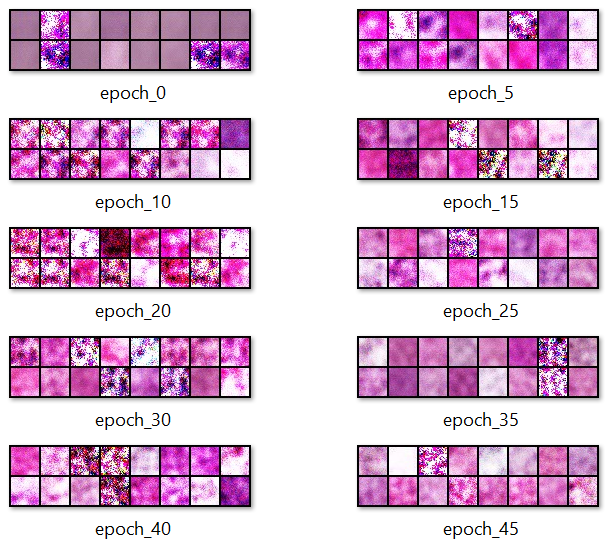

**Tensorboard Charts**

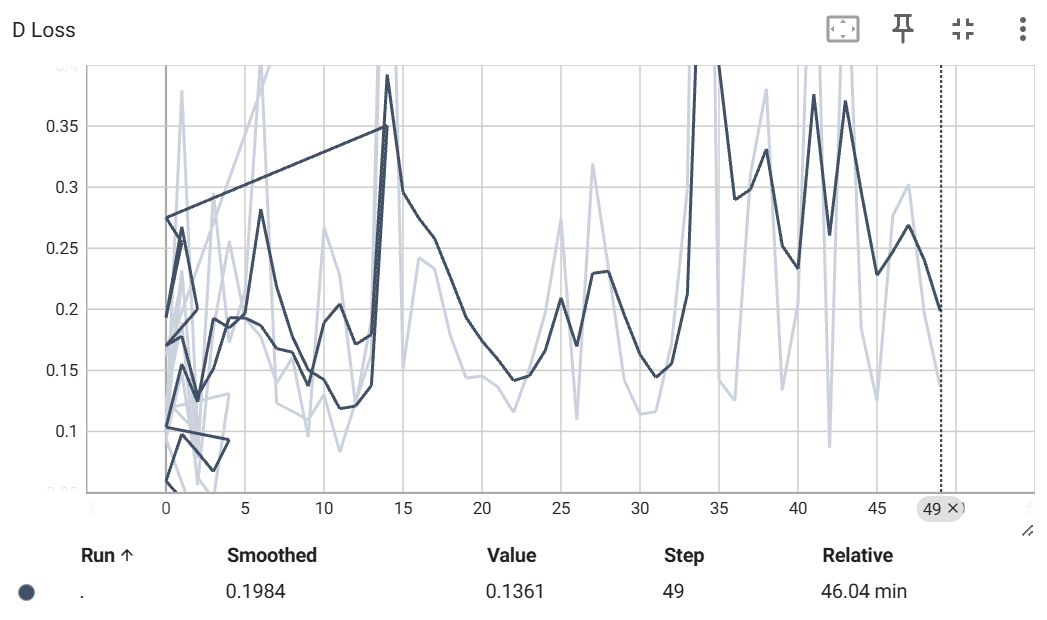

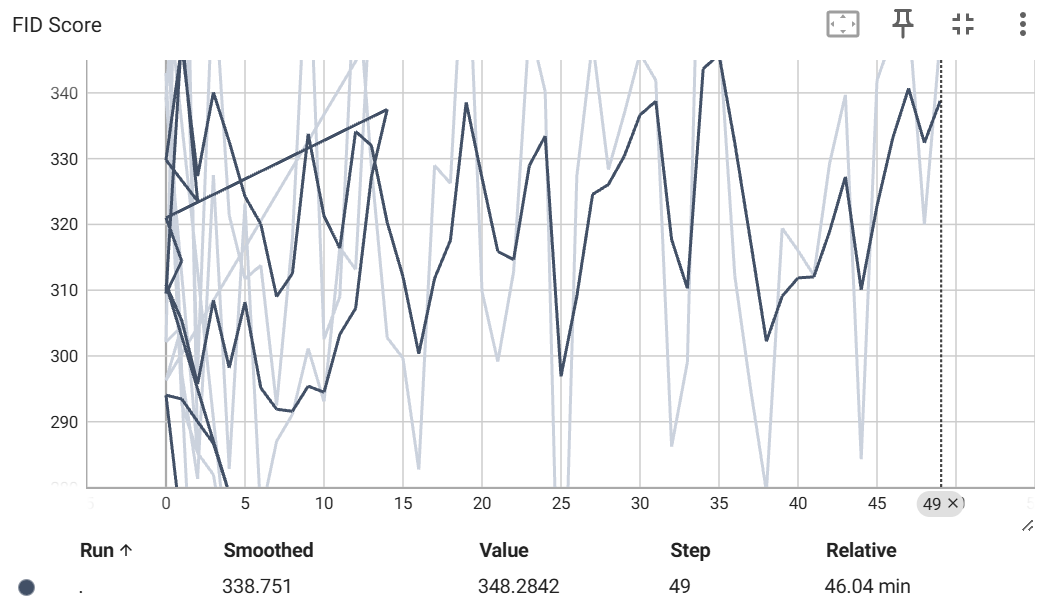

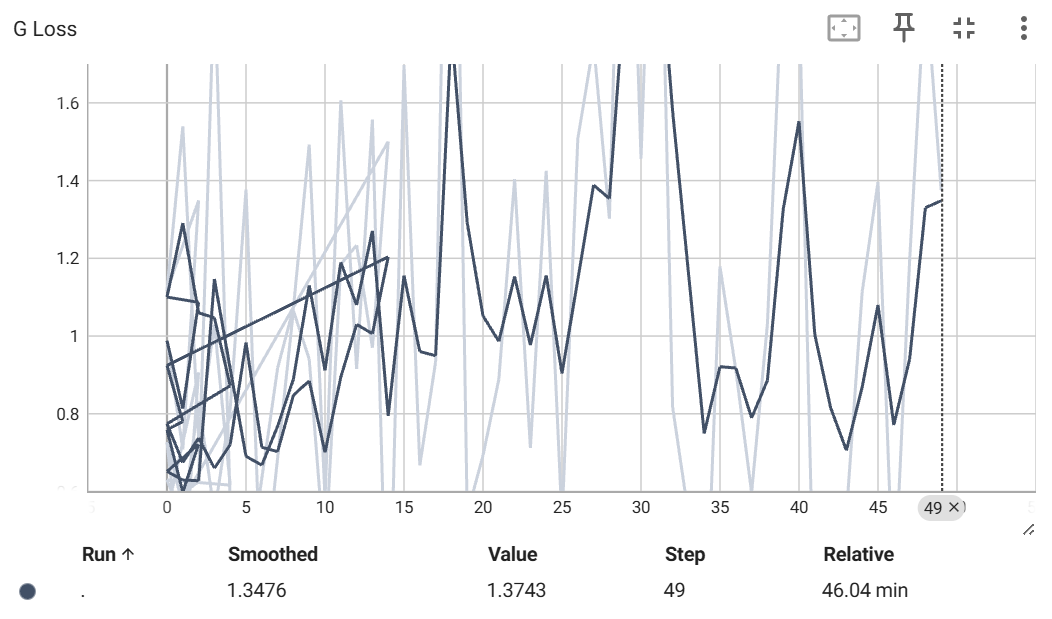

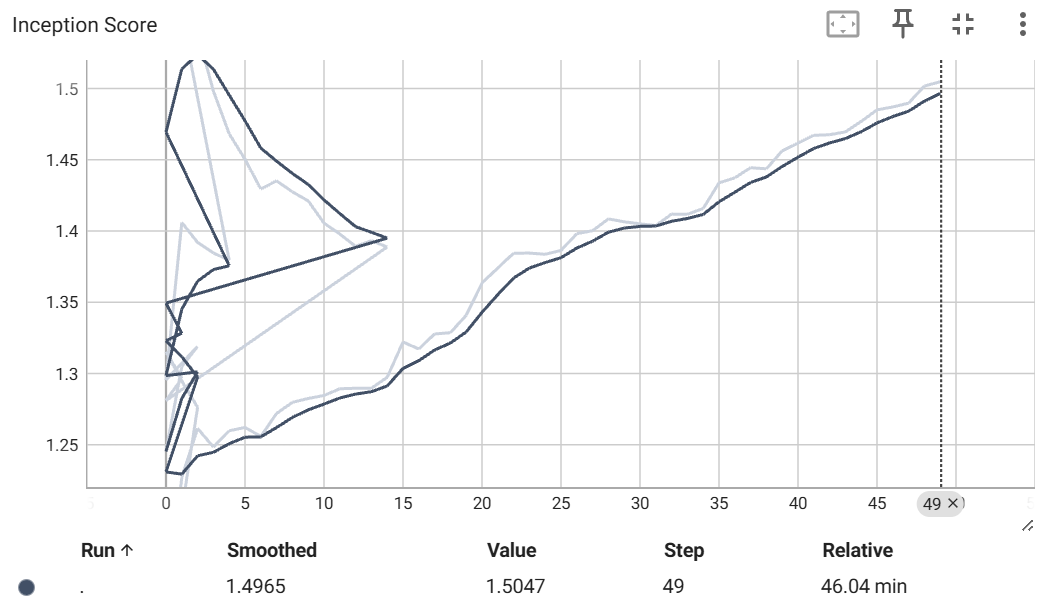

In [80]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os

# Path to logs folder
log_dir = "/kaggle/working/logs/LSGAN"

# Get the latest event file
event_files = [f for f in os.listdir(log_dir) if "events.out.tfevents" in f]
event_files.sort()
event_file = os.path.join(log_dir, event_files[-1])  # Last event file

# Load TensorBoard logs
event_acc = EventAccumulator(event_file, size_guidance={'scalars': 0})
event_acc.Reload()

# Extract FID and IS values
fid_values = event_acc.Scalars("FID Score") if "FID Score" in event_acc.Tags()['scalars'] else []
is_values = event_acc.Scalars("Inception Score") if "Inception Score" in event_acc.Tags()['scalars'] else []

# Get the final recorded values
final_fid = fid_values[-1].value if fid_values else "Not Found"
final_is = is_values[-1].value if is_values else "Not Found"

print(f"Final FID: {final_fid}")
print(f"Final IS: {final_is}")

Final FID: 348.28424072265625
Final IS: 1.504669427871704


A lower FID is better (ideal: ≤10 for high-quality images). Here, we have 348.28, which is quite high, meaning the generated images are **significantly different from real images** in terms of distribution.
This suggests that the LSGAN may still be generating **low-quality or unrealistic** images, and there might be **mode collapse or instability**.

A higher IS (ideal: >8 for high-quality images) means images are more diverse and contain meaningful objects.
1.50 is very low, indicating that the images **lack diversity** and do **not have clearly recognizable features**. This suggests that the generator is struggling to produce distinct, high-quality outputs.

Possible reasons include training instability, mode collapse, insufficient training or architecture issues.

Steps to improve include training for more epochs, tweaking the learning rate or using a better architecture (such as WGAN-GP or StyleGAN).

In [27]:
train_wgan(generator, discriminator, dataloader, epochs=16)

Saved: generated_images/WGAN/epoch_0.png
Epoch 1/16 | D Loss: -0.0764 | G Loss: -0.4695 | FID: 182.674
Epoch 2/16 | D Loss: 0.2336 | G Loss: -0.7857 | FID: 182.674
Epoch 3/16 | D Loss: -0.1050 | G Loss: 0.4366 | FID: 182.674
Saved: generated_images/WGAN/epoch_3.png
Epoch 4/16 | D Loss: 0.0479 | G Loss: -0.8376 | FID: 169.949
Epoch 5/16 | D Loss: 0.0566 | G Loss: -0.4819 | FID: 169.949
Epoch 6/16 | D Loss: -0.0681 | G Loss: 0.4763 | FID: 169.949
Saved: generated_images/WGAN/epoch_6.png
Epoch 7/16 | D Loss: -0.0850 | G Loss: 0.8380 | FID: 156.994
Epoch 8/16 | D Loss: 0.1542 | G Loss: -1.0215 | FID: 156.994
Epoch 9/16 | D Loss: -0.2162 | G Loss: -0.5673 | FID: 156.994
Saved: generated_images/WGAN/epoch_9.png
Epoch 10/16 | D Loss: -0.0311 | G Loss: -0.5627 | FID: 146.894
Epoch 11/16 | D Loss: -0.2429 | G Loss: 0.0528 | FID: 146.894
Epoch 12/16 | D Loss: -0.0604 | G Loss: 0.5948 | FID: 146.894
Saved: generated_images/WGAN/epoch_12.png
Epoch 13/16 | D Loss: 0.0422 | G Loss: -0.5762 | FID: 13

In [30]:
folder_name = "logs/WGAN"
zip_name = f"{folder_name}.zip"

shutil.make_archive(zip_name.replace(".zip", ""), 'zip', f"/kaggle/working/{folder_name}")

from IPython.display import FileLink
FileLink(zip_name)

/kaggle/working/logs/WGAN.zip

In [36]:
folder_name = "generated_images/WGAN"
zip_name = f"{folder_name}.zip"

shutil.make_archive(zip_name.replace(".zip", ""), 'zip', f"/kaggle/working/{folder_name}")

from IPython.display import FileLink
FileLink(zip_name)

/kaggle/working/generated_images/WGAN.zip

In [32]:
log_dir = "/kaggle/working/logs/WGAN"
print("Log Directory Exists:", os.path.exists(log_dir))
print("Files in Log Directory:", os.listdir(log_dir) if os.path.exists(log_dir) else "No logs found")

Log Directory Exists: True
Files in Log Directory: ['events.out.tfevents.1743132659.f467d74435fd.31.0', 'events.out.tfevents.1743133538.f467d74435fd.31.2', 'events.out.tfevents.1743132675.f467d74435fd.31.1']


**Generated Images**

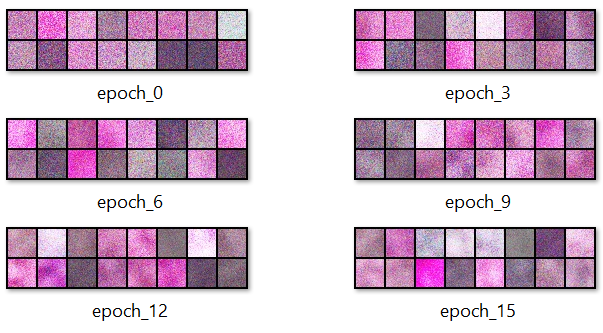

**Tensorboard Charts**

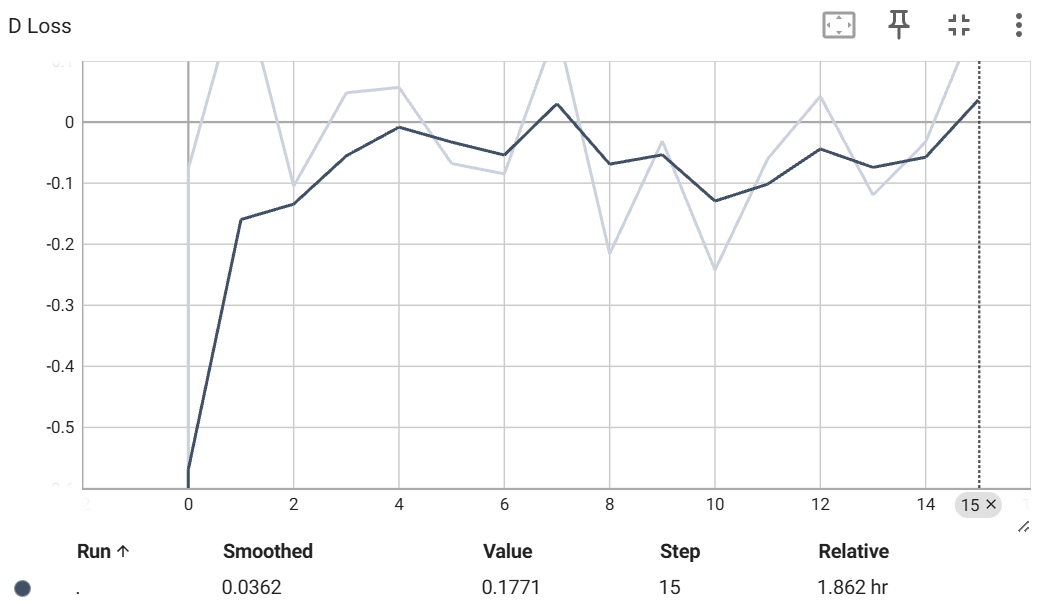

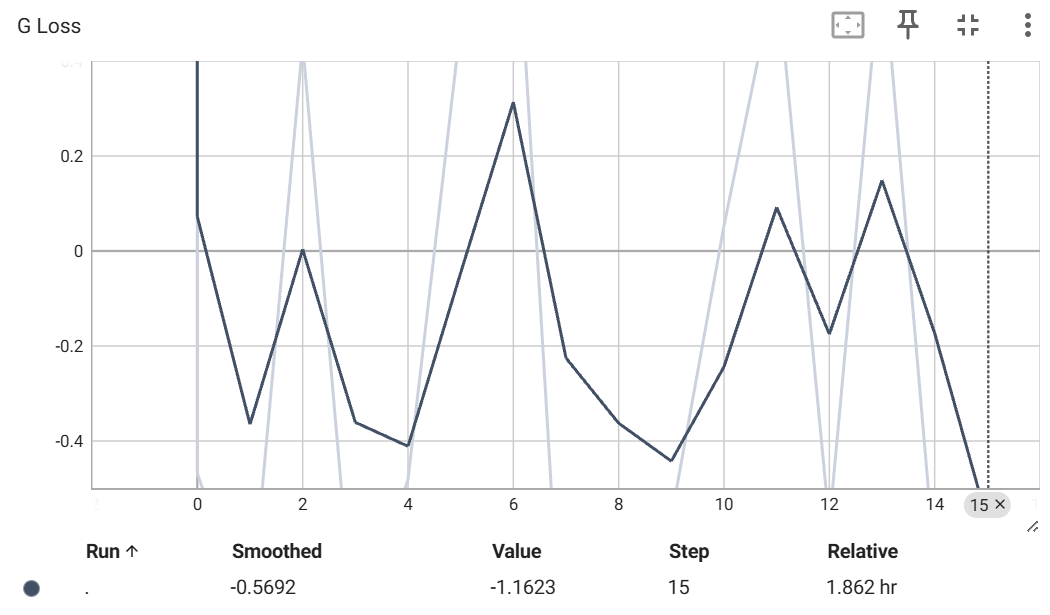

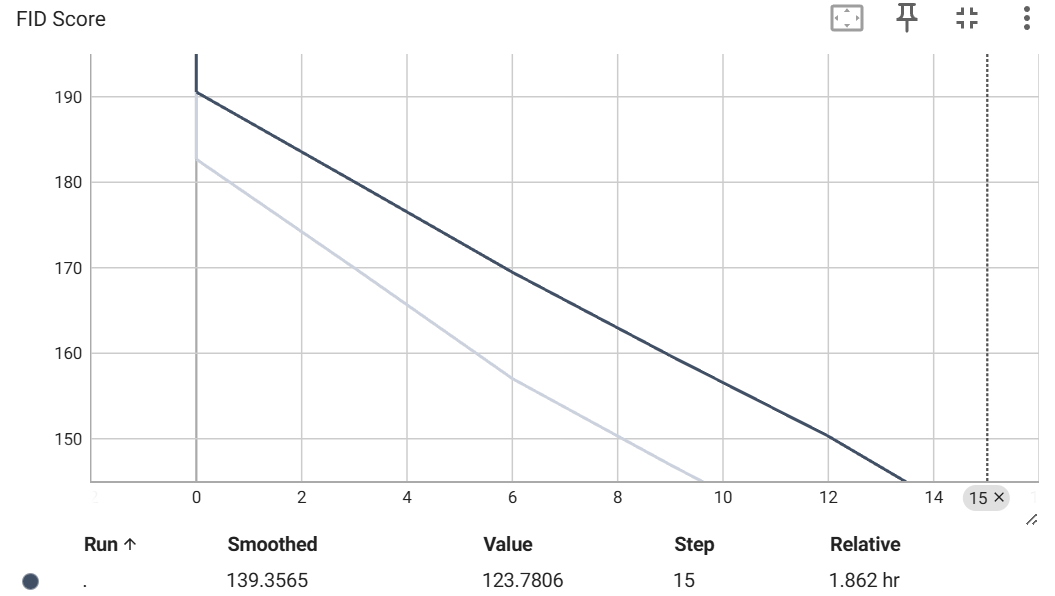

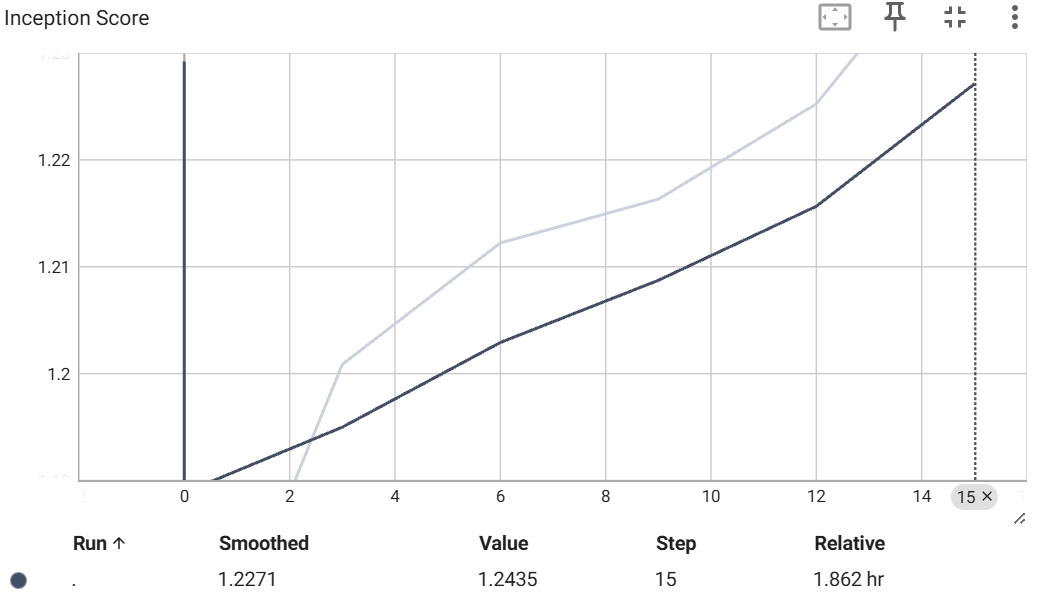

In [33]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [34]:
# Get the latest event file
event_files = [f for f in os.listdir(log_dir) if "events.out.tfevents" in f]
event_files.sort()
event_file = os.path.join(log_dir, event_files[-1])  # Last event file

# Load TensorBoard logs
event_acc = EventAccumulator(event_file, size_guidance={'scalars': 0})
event_acc.Reload()

# Extract FID and IS values
fid_values = event_acc.Scalars("FID Score") if "FID Score" in event_acc.Tags()['scalars'] else []
is_values = event_acc.Scalars("Inception Score") if "Inception Score" in event_acc.Tags()['scalars'] else []

# Get the final recorded values
final_fid = fid_values[-1].value if fid_values else "Not Found"
final_is = is_values[-1].value if is_values else "Not Found"

print(f"Final FID: {final_fid}")
print(f"Final IS: {final_is}")

Final FID: 123.7806167602539
Final IS: 1.2434754371643066


The **FID score of 123.78** suggests that the generated images are far from real, while the **Inception Score of 1.24** indicates low diversity and quality. But we could notice the **reducing FID** after each epoch, indicating the model's improvement. WGAN may need more training, better hyperparameters, or a stronger generator to improve results. Issues like weight clipping limitations or an overly strong discriminator could be affecting performance. Switching to **WGAN-GP**, increasing training epochs, or adjusting model architecture may help enhance image quality.

In [35]:
torch.save(generator.state_dict(), "generator_wgan.pth")
torch.save(discriminator.state_dict(), "discriminator_wgan.pth")

In [20]:
train_wgan_gp(generator, discriminator, dataloader, epochs=31)

Saved: generated_images/WGAN-GP/epoch_0.png
Epoch 1/31 | D Loss: 1.0687 | G Loss: 14.7689  | FID: 189.287
Epoch 2/31 | D Loss: 13.1990 | G Loss: 7.3652  | FID: 189.287
Epoch 3/31 | D Loss: 102.9421 | G Loss: -144.3378  | FID: 189.287
Saved: generated_images/WGAN-GP/epoch_3.png
Epoch 4/31 | D Loss: 254.6095 | G Loss: -180.6264  | FID: 167.089
Epoch 5/31 | D Loss: 43.1222 | G Loss: -73.3826  | FID: 167.089
Epoch 6/31 | D Loss: -7.1703 | G Loss: 108.0251  | FID: 167.089
Saved: generated_images/WGAN-GP/epoch_6.png
Epoch 7/31 | D Loss: -9.8945 | G Loss: 83.7582  | FID: 166.482
Epoch 8/31 | D Loss: 19.7048 | G Loss: 82.4526  | FID: 166.482
Epoch 9/31 | D Loss: 2.3903 | G Loss: -5.3290  | FID: 166.482
Saved: generated_images/WGAN-GP/epoch_9.png
Epoch 10/31 | D Loss: -11.8760 | G Loss: 84.9806  | FID: 161.782
Epoch 11/31 | D Loss: 2.8470 | G Loss: 145.6324  | FID: 161.782
Epoch 12/31 | D Loss: 5.3643 | G Loss: 41.3765  | FID: 161.782
Saved: generated_images/WGAN-GP/epoch_12.png
Epoch 13/31 | D

In [22]:
import shutil
folder_name = "logs/WGAN-GP"
zip_name = f"{folder_name}.zip"

shutil.make_archive(zip_name.replace(".zip", ""), 'zip', f"/kaggle/working/{folder_name}")

from IPython.display import FileLink
FileLink(zip_name)

/kaggle/working/logs/WGAN-GP.zip

In [23]:
folder_name = "generated_images/WGAN-GP"
zip_name = f"{folder_name}.zip"

shutil.make_archive(zip_name.replace(".zip", ""), 'zip', f"/kaggle/working/{folder_name}")

from IPython.display import FileLink
FileLink(zip_name)

/kaggle/working/generated_images/WGAN-GP.zip

In [24]:
log_dir = "/kaggle/working/logs/WGAN-GP"
print("Log Directory Exists:", os.path.exists(log_dir))
print("Files in Log Directory:", os.listdir(log_dir) if os.path.exists(log_dir) else "No logs found")

Log Directory Exists: True
Files in Log Directory: ['events.out.tfevents.1743168712.492579b1941c.31.0', 'events.out.tfevents.1743168796.492579b1941c.31.1']


**Generated Images**

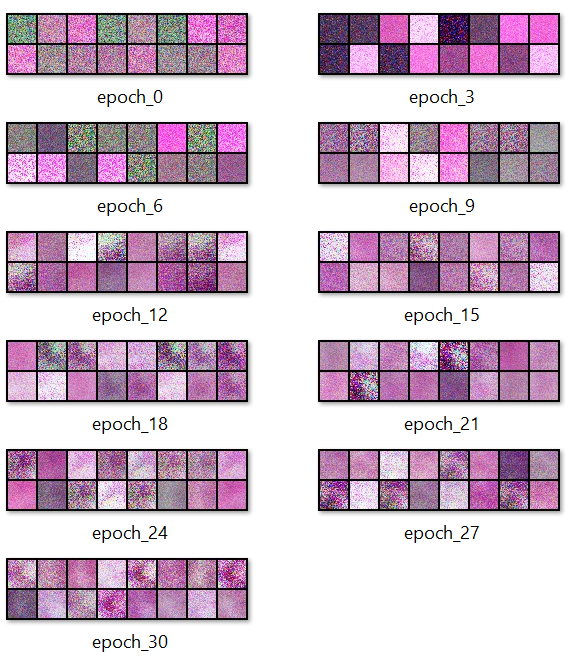

**Tensorboard Charts**

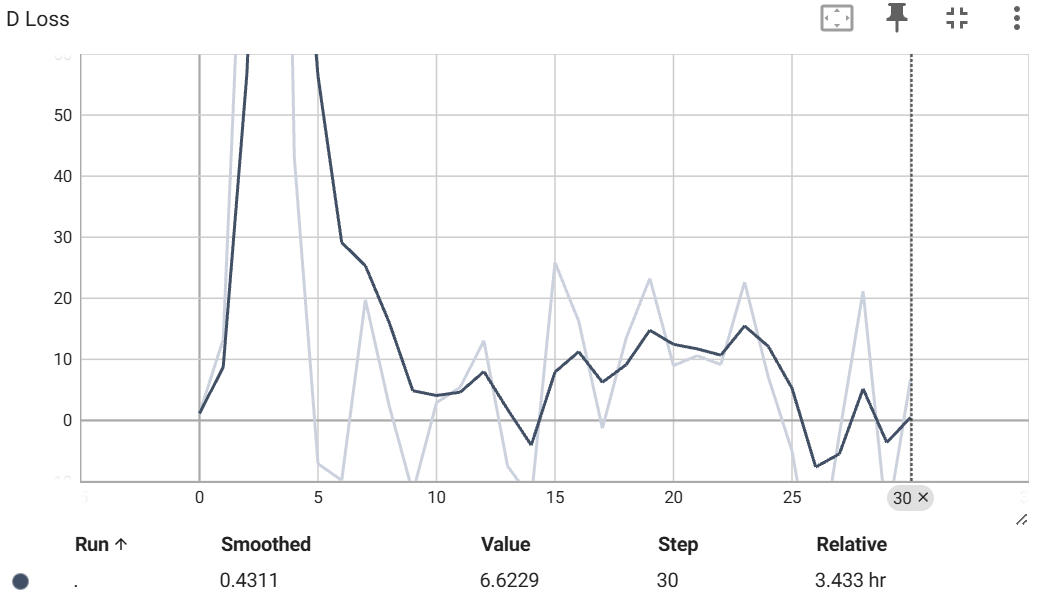

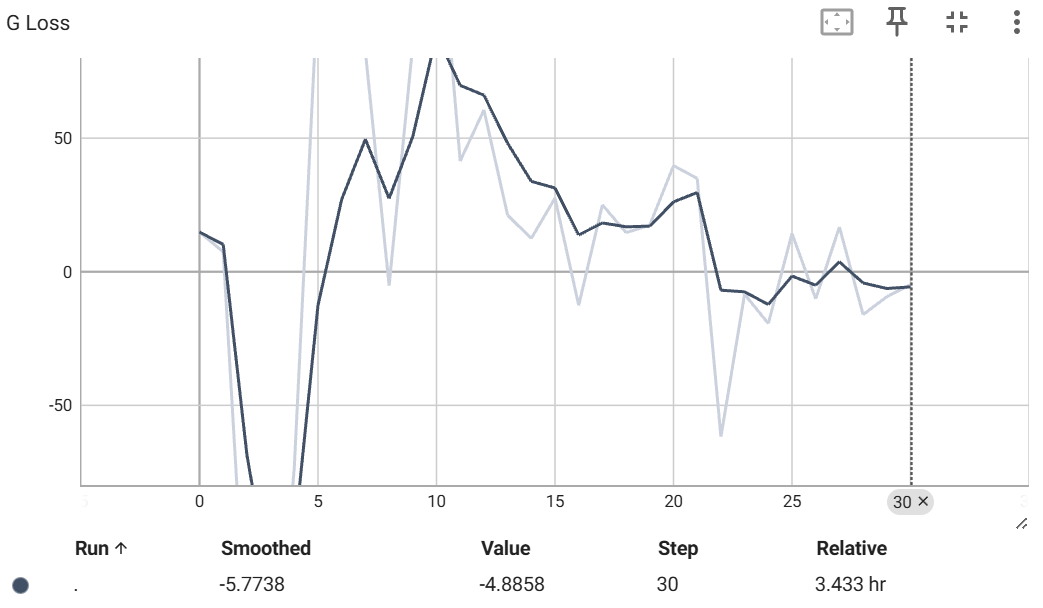

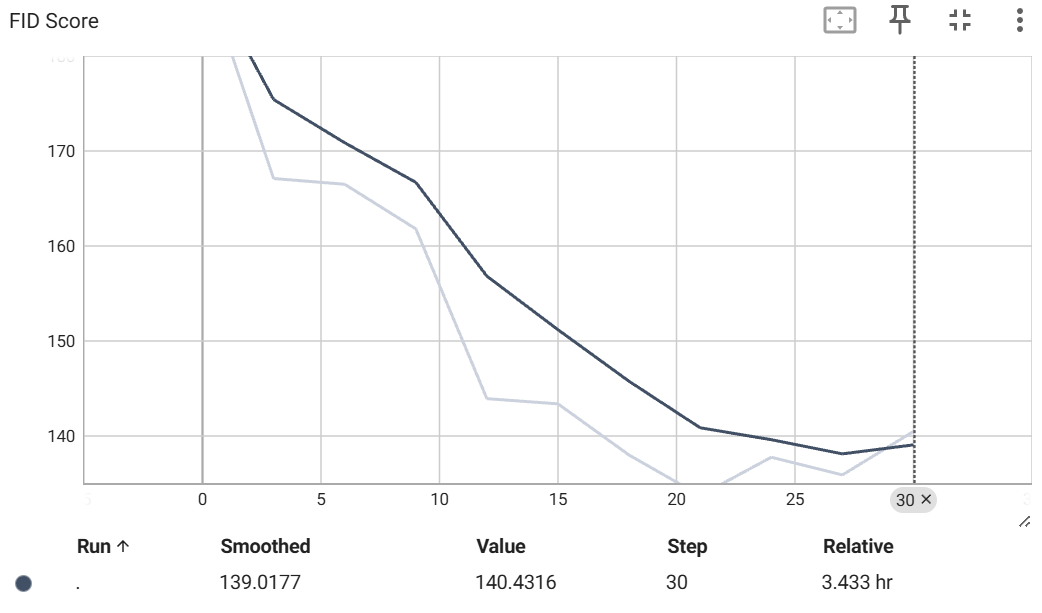

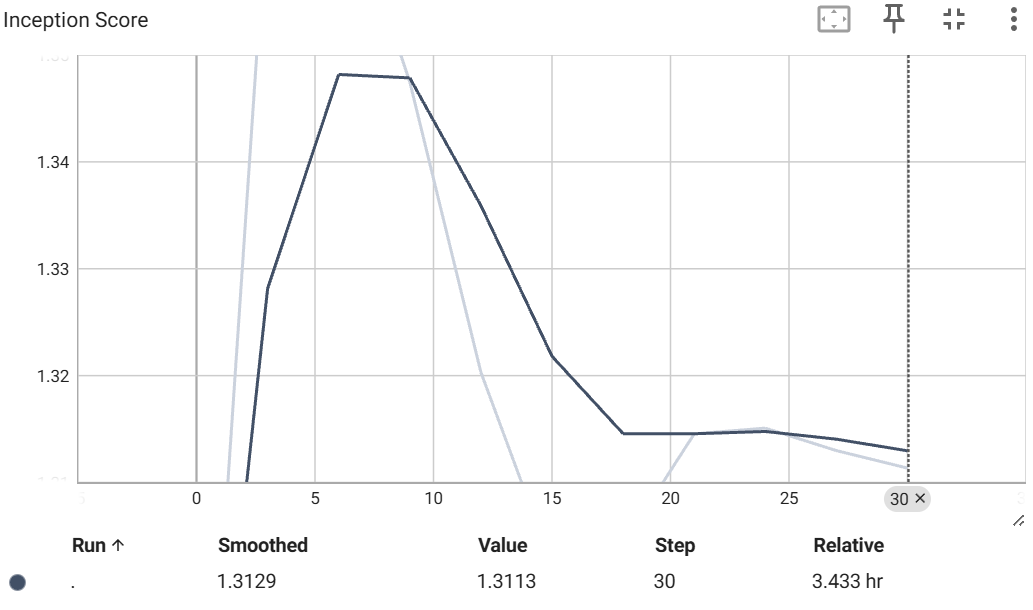

In [25]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [26]:
# Get the latest event file
event_files = [f for f in os.listdir(log_dir) if "events.out.tfevents" in f]
event_files.sort()
event_file = os.path.join(log_dir, event_files[-1])  # Last event file

# Load TensorBoard logs
event_acc = EventAccumulator(event_file, size_guidance={'scalars': 0})
event_acc.Reload()

# Extract FID and IS values
fid_values = event_acc.Scalars("FID Score") if "FID Score" in event_acc.Tags()['scalars'] else []
is_values = event_acc.Scalars("Inception Score") if "Inception Score" in event_acc.Tags()['scalars'] else []

# Get the final recorded values
final_fid = fid_values[-1].value if fid_values else "Not Found"
final_is = is_values[-1].value if is_values else "Not Found"

print(f"Final FID: {final_fid}")
print(f"Final IS: {final_is}")

Final FID: 140.43162536621094
Final IS: 1.3113017082214355


The final **FID of 140.43** and **Inception Score (IS) of 1.31** suggest that the generated images exhibit **moderate realism** but still **lack diversity and structural fidelity**. The relatively high FID indicates a noticeable gap between generated and real distributions, implying that the model struggles with fine-grained details. The low IS reflects limited sample diversity, suggesting mode collapse or insufficient feature variation. Refining training stability, adjusting hyperparameters, or employing architectural improvements like spectral normalization or self-attention could enhance generation quality.

In [28]:
torch.save(generator.state_dict(), "generator_wgan_gp.pth")
torch.save(discriminator.state_dict(), "discriminator_wgan_gp.pth")